__<h2>Importent Setup and library:</h2>__

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

dataset = 'paultimothymooney/chest-xray-pneumonia'
zip_name = dataset.split('/')[-1] + '.zip'

!kaggle datasets download -d {dataset}
!unzip -q {zip_name} -d /content/

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential

from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [3]:
import pathlib
data_dir = "/content/chest_xray/chest_xray"
data_dir_train = "/content/chest_xray/chest_xray/train"
data_dir_validation = "/content/chest_xray/chest_xray/val"
data_dir_test = "/content/chest_xray/chest_xray/test"


Data cleaning

In [4]:
from pathlib import Path
import imghdr

data_dir = "/content/chest_xray/chest_xray"
image_extensions = [".png", ".svg", ".gif", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

<ipython-input-4-32fc7e319159>:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
img_height,img_width=300, 300
batch_size=64
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_validation,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


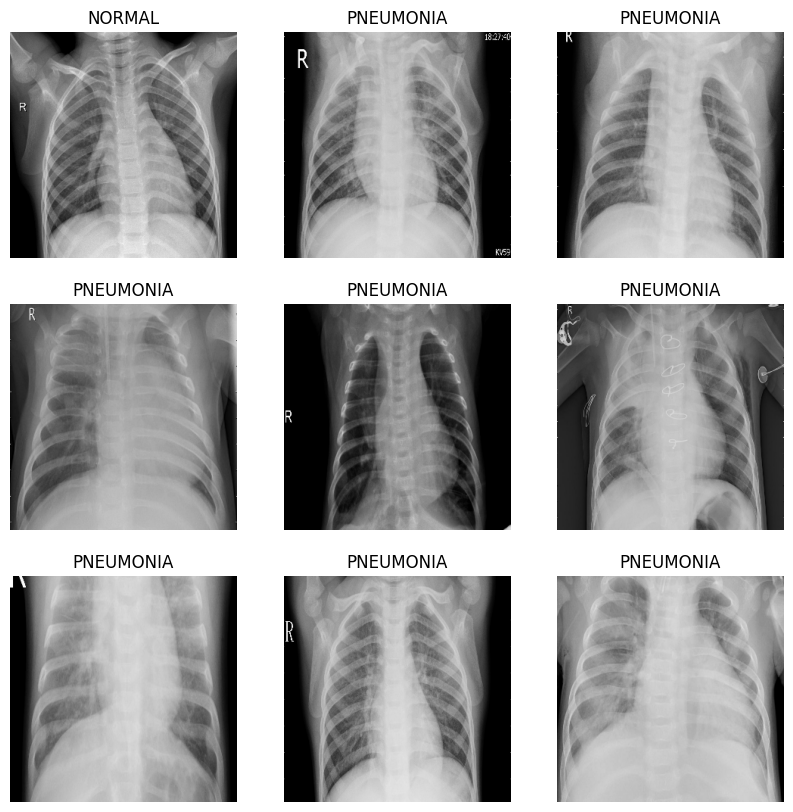

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [28]:
from tensorflow.keras import regularizers

num_classes = 2

model = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.6971 - loss: 58.5579 - val_accuracy: 0.5625 - val_loss: 2.7164
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8002 - loss: 2.4234 - val_accuracy: 0.5625 - val_loss: 2.3484
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8205 - loss: 2.0884 - val_accuracy: 0.6875 - val_loss: 2.1075
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.8520 - loss: 1.8522 - val_accuracy: 0.7500 - val_loss: 1.8780
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8549 - loss: 1.7087 - val_accuracy: 0.8125 - val_loss: 1.6003
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8719 - loss: 1.5522 - val_accuracy: 0.6250 - val_loss: 2.0608
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8518 - loss: 1.4977 - val_accuracy: 0.7500 - val_loss: 1.6447
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8729 - loss: 1.3425 - val_accuracy: 0.7500 - 

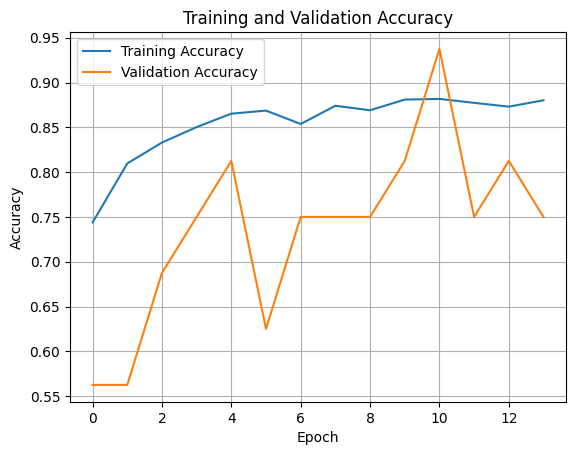

In [31]:
import matplotlib.pyplot as plt

# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

# If you used validation_data in model.fit(), you can also plot validation accuracy
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [32]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [33]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.7939 - loss: 1.2625
Test Loss: 1.2438
Test Accuracy: 0.8077


In [34]:
model.save("nndl.keras")

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Flower Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (180,180)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.

        img_reshape = img[np.newaxis,...]

        prediction = model.predict(img_reshape)

        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)